In [102]:
#start/ importing begging libraries
import requests
import json
import csv  
import urllib.request
import pandas as pd
print("yn = yes or no")
print("green fn")
print("yellow fn")
print("red fn")
print("blue fn")

In [ ]:
#california natural resource agency 

url = 'https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=8ea91e09-3c84-4eba-9489-3ab3b08adfd0&limit=10000' 
# Send a GET request to the API
response = requests.get(url)
# Parse the JSON response
response_dict = response.json()
filtered_records = []
# Accessing records and printing the value of YEAR_ for each record
if "result" in response_dict and "records" in response_dict["result"]:
    for record in  response_dict["result"]["records"]:
        year_value = record.get("YEAR_")  # Access YEAR_ from each record
        try:
            # Only print the entire record where YEAR_ is 2000 or later
            if int(year_value) >= 2000:
               filtered_records.append(record)
        except (ValueError, TypeError):
            # Skip :ecords where YEAR_ is not a valid number
            continue

df = pd.DataFrame(filtered_records)
df.to_csv('cnra_data.csv', index=False, encoding='utf-8')
# Write the DataFrame to a CSV file
# filter the data by alarm_date

df1 = pd.read_csv('dont_delete/cnra_data.csv') # read the csv file
df1['ALARM_DATE'] = pd.to_datetime(df1['ALARM_DATE'], errors='coerce') # convert the alarm_date column to datetime
#df1['ALARM_DATE'] = df1['ALARM_DATE'].dt.tz_convert('UTC')
df1_sorted = df1.sort_values(by = 'ALARM_DATE', ascending=False) # filter the data by alarm_date
df1_sorted.to_csv('exported_data/cnra_data_sorted.csv', index=False) # save the filtered data to a new csv file

In [ ]:
#order by incident_date_created  
# Read the CSV file
df2 = pd.read_csv('dont_delete/fire_ca.csv')
fire = df2[df2['incident_name'].str.contains('Fire', case=False, na=False)].copy()
# copying onlie fire data
# Convert 'incident_date_created' to datetime, coercing errors to NaT
fire['incident_date_created'] = pd.to_datetime(fire['incident_date_created'], errors='coerce')
# Sort by 'incident_date_created' in descending order
df_sorted = fire.sort_values(by='incident_date_created', ascending=False)
# Save the sorted DataFrame to a new CSV file
df_sorted.to_csv('sorted_by_year.csv', index=False) 

In [104]:
df = pd.read_csv('exported_data/cnra_data_sorted.csv')
        
    # Remove multiple columns
columns_to_remove = ['OBJECTID', '_id', 'YEAR_','STATE','AGENCY','UNIT_ID','INC_NUM','OBJECTIVE','COMMENTS','IRWINID','FIRE_NUM','DECADES','COMPLEX_ID']
# OBJECTID
#_id
# YEAR_
# STATE
# AGENCY 
# UNIT_ID

# INC_NUM
# OBJECTIVE 
# COMMENTS 
# IRWINID 
# FIRE_NUM
# COMPLEX_ID 
# DECADES

df.drop(columns=columns_to_remove, axis=1, inplace=True)

In [ ]:
'this gets the data from google earth engine from landfire,'
'we will make it so that we collect the vegetation type(returns a value corresponding to the vegation)'
'the evc is the vegation cover, this returns a code corresponding to vegetation look at the landfire documentation for more information'

import ee
import pandas as pd

# Initialize EE
ee.Initialize(project='fuzz-464001')
# Define a point (Northern California coastal area)
point = ee.Geometry.Point([-120.87, 41.44])
# Load LANDFIRE datasets (corrected case sensitivity)
evc_image = ee.Image('LANDFIRE/Vegetation/EVC/v1_4_0/CONUS')
evt_image = ee.Image('LANDFIRE/Vegetation/EVT/v1_4_0/CONUS') 
# Print band names
#print(evc_image)
print("EVC Bands:", evc_image.bandNames().getInfo())  # Should show ['EVC']
print("EVT Bands:", evt_image.bandNames().getInfo())  # Should show ['EVT']
# Get pixel values
evc_result = evc_image.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry = point ,
    scale=30  # 30m resolution
    
).getInfo()  # Directly get the Python dictionary

evt_result = evt_image.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=point,
    scale=30
).getInfo()

print("\nEVC Value (Cover %):", evc_result['EVC'])
print("EVT Value (Type Code):", evt_result['EVT'])


image_biomass = ee.Image('LARSE/GEDI/GEDI04_B_002')
layer1 = image_biomass.select('MU')
biomass_result = layer1.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=point,
    scale=30
).getInfo()

confidence_layer = image_biomass.select('PE')
confidence_result = confidence_layer.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=point,
    scale=30
).getInfo()




' for this we are going to use the GEDI dataset, which provides biomass and confidence values'
''

'how much biomass is bad in the area'
'VERY low amount of bioass = 0-10 MG/ha'
'medium amount of biomass = 10-50 MG/ha'
'medium to high amount of biomass = 50-150 MG/ha'
'high amount of biomass = 150+ MG/ha  forest area'

'LOWER MEANS BAD 0-50'
'80-100 PERCENT CONFIDENCE IS GOOD'


'high amount of biomass = '

print("\nBiomass Value:", biomass_result['MU'])
print("Confidence Value:", confidence_result['PE'])


'''
'{firename,lat,lon}  [evt,evc,[biomass,confidence]]'
'nclude building material for each fire, for the model incorporate the building material uncertanty to account for brickk and other non flammable materials'
'using microsoft building footprint data'
ee.features.FeatureCollection('Microsoft/USBuildingFootprints/CONUS')
'''












EVC Bands: ['EVC']
EVT Bands: ['EVT']

EVC Value (Cover %): 103
EVT Value (Type Code): 3921

Biomass Value: 1.9107507467269897
Confidence Value: 36


'{firename,lat,lon}  [evt,evc,[biomass,confidence]]'

In [1]:
# arc gis

import arcpy
from arcpy.sa import *
from datetime import datetime

def get_arcgis_biomass(lat, lon):
    """
    Fetch vegetation and biomass data from ArcGIS sources for a specific point.
    
    Args:
        lat (float): Latitude
        lon (float): Longitude
        
    Returns:
        dict: {
            'EVC': Vegetation cover (%),
            'EVT': Vegetation type code,
            'biomass': Biomass (Mg/ha),
            'confidence': Confidence score,
            'timestamp': Processing time
        }
    """
    # Create a point geometry
    point = arcpy.Point(lon, lat)
    pt_geometry = arcpy.Geometry('POINT', point, spatial_ref=arcpy.SpatialReference(4326))
    
    # Initialize results dict
    results = {
        'EVC': None,
        'EVT': None,
        'biomass': None,
        'confidence': None,
        'timestamp': datetime.now().isoformat()
    }
    
    try:
        # --- 1. Get LANDFIRE Vegetation Data ---
        # Connect to Living Atlas LANDFIRE services
        lf_evc = r"https://landfire.cr.usgs.gov/arcgis/rest/services/Landfire/US_200/ImageServer/11"  # EVC
        lf_evt = r"https://landfire.cr.usgs.gov/arcgis/rest/services/Landfire/US_200/ImageServer/10"  # EVT
        
        # Extract pixel values
        results['EVC'] = arcpy.ia.GetCellValue(lf_evc, pt_geometry).getOutput(0)
        results['EVT'] = arcpy.ia.GetCellValue(lf_evt, pt_geometry).getOutput(0)
        
        # --- 2. Get Biomass Data ---
        # USFS Tree Carbon (2021) from Living Atlas
        usfs_biomass = r"https://services.arcgis.com/rOo16HdIMeOBI4Mb/arcgis/rest/services/USFS_TreeCarbon_2021/ImageServer"
        results['biomass'] = arcpy.ia.GetCellValue(usfs_biomass, pt_geometry).getOutput(0)
        
        # Confidence (using NLCD confidence layer as proxy)
        nlcd_conf = r"https://www.mrlc.gov/arcgis/rest/services/LandCover/USGS_EROS_LandCover_NLCD/ImageServer/1"
        results['confidence'] = arcpy.ia.GetCellValue(nlcd_conf, pt_geometry).getOutput(0)
        
    except Exception as e:
        arcpy.AddError(f"Failed to extract data: {str(e)}")
    
    return results

# Example usage:
print(get_arcgis_biomass(34.05, -118.25))  # Los Angeles coordinates

ModuleNotFoundError: No module named 'arcpy'

In [3]:
import arcgis
from arcgis.gis import GIS
# Connect to ArcGIS Online
gis = GIS()  #

In [12]:
search_results = gis.content.search("Microsoft Building Footprints - Features", item_type="Feature Layer")
building_layer = search_results[0]
building_layer

<Item title:"Microsoft Building Footprints - Features" type:Feature Layer Collection owner:sbreyer_esri>

In [14]:
building_layer = building_layer.layers[0]

##Example: Query a small bounding box (e.g., a city or area)
bbox = {
    "xmin": -120.4643,
    "ymin": 37.7590,
    "xmax": -120.4623,
    "ymax": 37.7610,
    "spatialReference": {"wkid": 4326}
}

#Query features in that box
results = building_layer.query(geometry=bbox, return_geometry=True, out_fields="*")
buildings_df = results.sdf  # Convert to SpatialDataFrame

#Show count and preview
print(f"Found {len(buildings_df)} buildings")
buildings_df.head()

KeyboardInterrupt: 

ModuleNotFoundError: No module named 'arcpy'

✅ Image saved to landfire_evt.png
Visualizing the raster...


C:\Users\roman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


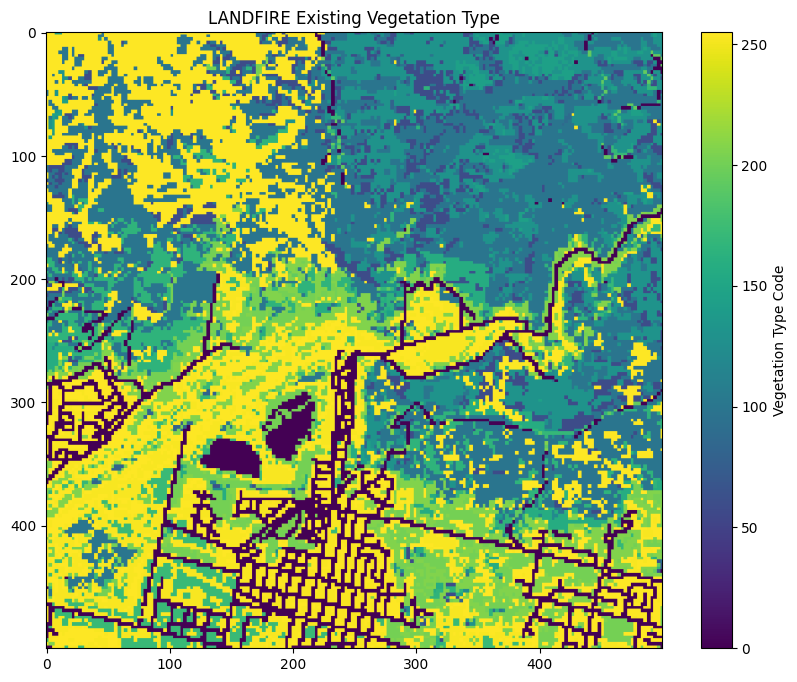

In [24]:
from arcgis.gis import GIS
from arcgis.raster import ImageryLayer
import numpy as np
import rasterio
from io import BytesIO
import matplotlib.pyplot as plt

# Connect to GIS (no credentials needed for public service)
gis = GIS()

# LANDFIRE Existing Vegetation Type service
url = "https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_Landfire/US_ExistingVegType_v200/ImageServer"
layer = ImageryLayer(url, gis)

# Define your point and area of interest
x = -117.91049
y = 34.160265
acres_burned = 4237
meters_burned = 4046 * acres_burned
r = (meters_burned / np.pi) ** 0.5  # radius in meters

# Convert meters to degrees
meters_per_degree_lat = 111320
meters_per_degree_lon = meters_per_degree_lat * np.cos(np.radians(y))
r_deg_lat = r / meters_per_degree_lat
r_deg_lon = r / meters_per_degree_lon

extent = {
    "xmin": x - r_deg_lon,
    "ymin": y - r_deg_lat,
    "xmax": x + r_deg_lon,
    "ymax": y + r_deg_lat,
    "spatialReference": {"wkid": 4326}
}

try:
    # Correct export_image usage
    img_data = layer.export_image(
        bbox=extent,
        size=[500, 500],
        f='image',  # This is the correct parameter for format
        rendering_rule={"rasterFunction": "None"}
    )
    
    if img_data:
        # Save to file (as PNG since that's what we're getting)
        output_path = "landfire_evt.png"
        with open(output_path, "wb") as f:
            f.write(img_data)
        print(f"✅ Image saved to {output_path}")
        
        # Visualize
        print("Visualizing the raster...")
        with rasterio.open(output_path) as src:
            raster = src.read(1)
            
            plt.figure(figsize=(10, 8))
            img = plt.imshow(raster, cmap='viridis')
            plt.colorbar(img, label="Vegetation Type Code")
            plt.title("LANDFIRE Existing Vegetation Type")
            plt.show()
        
except Exception as e:
    print(f"Error: {str(e)}")
    print("Alternative approaches:")
    print("1. Try using the export() method instead of export_image()")
    print("2. Access the service through ArcGIS Online web interface")
    print("3. Use the REST endpoint directly with requests:")
    print(f"   {url}/exportImage?bbox={extent['xmin']},{extent['ymin']},{extent['xmax']},{extent['ymax']}&size=500,500&f=image")

In [22]:
print(f"Raster shape: {raster.shape}")
print(f"Data type: {raster.dtype}")
print(f"Minimum value: {np.min(raster)}")
print(f"Maximum value: {np.max(raster)}")
print(f"Mean value: {np.mean(raster)}")
print(f"Unique values: {np.unique(raster)}") # Especially useful for classified data like EVT

Raster shape: (500, 500)
Data type: uint8
Minimum value: 0
Maximum value: 255
Mean value: 236.304852
Unique values: [  0  81 100 112 170 194 202 210 227 250 255]
